# Load Data

In [12]:
import os
import sys

feat_dir = os.path.join('..', 'ML_Forex_Forecasting')
sys.path.append(feat_dir)

In [13]:
import pandas as pd
from generate_features import generate_features

In [14]:
usd_eur = pd.read_csv(os.path.join(feat_dir, "./USDEUR=X.csv"), parse_dates=['Date'])
eur_chf = pd.read_csv(os.path.join(feat_dir, "./EURCHF=X.csv"), parse_dates=['Date'])
eur_gbp = pd.read_csv(os.path.join(feat_dir, "./EURGBP=X.csv"), parse_dates=['Date'])
gbp_chf = pd.read_csv(os.path.join(feat_dir, "./GBPCHF=X.csv"), parse_dates=['Date'])
usd_chf = pd.read_csv(os.path.join(feat_dir, "./USDCHF=X.csv"), parse_dates=['Date'])
usd_gbp = pd.read_csv(os.path.join(feat_dir, "./USDGBP=X.csv"), parse_dates=['Date'])

In [15]:
data = eur_gbp

In [16]:
feats = generate_features(data)
print(f"EUR/CHF Features shape: {feats.shape}")
display(feats.head())

EUR/CHF Features shape: (262, 28)


,Date,opt_sine_offset,opt_sine_amp,opt_sine_freq,opt_sine_phase,opt_fourier_offset,opt_fourier_cosamp,opt_fourier_cosfreq,opt_fourier_cosphase,opt_fourier_sinamp,...,ROC1,ROC5,ROC20,WILLIAMS14,RSI14,CMO9,DEMA9,TEMA9,STOCH14,Close
0,2023-11-04,0.870904,1.000000,1.000037,-0.000015,0.867808,-0.000526,1.301513,-1.361042,-0.000543,...,-1453.991975,-348.869503,-41.157688,-9529.994883,47.994844,-11.584598,-0.000661,-0.001663,47.994844,0.86707
1,2023-11-03,0.870947,1.000000,0.999947,-0.000017,0.867811,-0.015800,1.020890,1.711873,-0.015565,...,-116.465040,-341.141141,-104.869782,-7160.110705,56.730784,11.865286,0.000709,0.000153,56.730784,0.87077
2,2023-11-02,0.871637,0.996344,0.999789,0.001560,0.867625,0.772528,1.061765,-2.182285,-0.772383,...,-937.812560,-161.958133,-68.494154,-7174.840656,52.854249,0.285988,0.000739,0.000157,52.854249,0.86897
3,2023-11-01,0.871884,0.989384,1.000117,-0.001315,0.867384,2.653029,0.870333,-2.006040,-2.653532,...,-90.210953,-69.978798,-104.860241,-7160.683537,57.447552,13.144303,0.001656,0.001500,57.447552,0.87070
4,2023-10-31,0.871353,1.000000,1.000087,0.000039,0.867143,-0.098707,1.040771,0.414727,-0.099181,...,36.114855,390.145618,-149.912800,-6661.598232,62.395395,27.615052,0.002024,0.002197,62.395395,0.87240


In [17]:
feats.columns

Index(['Date', 'opt_sine_offset', 'opt_sine_amp', 'opt_sine_freq',
       'opt_sine_phase', 'opt_fourier_offset', 'opt_fourier_cosamp',
       'opt_fourier_cosfreq', 'opt_fourier_cosphase', 'opt_fourier_sinamp',
       'opt_fourier_sinfreq', 'opt_fourier_sinphase', 't', 'Slopes',
       'autocorrelation', 'pca', 'ica', 'mean_abs', 'ROC1', 'ROC5', 'ROC20',
       'WILLIAMS14', 'RSI14', 'CMO9', 'DEMA9', 'TEMA9', 'STOCH14', 'Close'],
      dtype='object')

# 1. Prepare X_train, Y_train, X_test, Y_test

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
# use the past 20 days to train the model
def prepare_train_test(df: pd.DataFrame, n_lag_features: int = 10, test_size: float = 0.2, n_days_ahead: int = 5):
    df = df.copy()
    df.drop(['t'], axis=1)
    XY = []
    
    for col in df.columns:
        if col == 'Close':
            closes = pd.DataFrame()
            for i in range(1, n_days_ahead + 1):
                lag_feature_name = f'{col}_Day_{i}'
                closes[lag_feature_name] = df[col].shift(i)
            XY.append(closes)
        elif col != 'Date':
            col_lag_features = pd.DataFrame()
            for i in range(n_lag_features):
                lag_feature_name = f'{col}_Lag_{i}'
                col_lag_features[lag_feature_name] = df[col].shift(-i)
            XY.append(col_lag_features)
    df = pd.concat(XY, axis=1)
    df.dropna(inplace=True)
    
    Y_columns = [f'{col}_Day_{i}' for i in range(1, n_days_ahead + 1)]
    Y = df[Y_columns]
    X = df.drop(columns=Y_columns, axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

In [20]:
n_days_ahead = 5 # predict the next 5 days
n_lag_features = 10 # how many past days used for predictions

In [21]:
X_train, X_test, Y_train, Y_test = prepare_train_test(feats, n_lag_features=n_lag_features, n_days_ahead=n_days_ahead)

In [22]:
X_train.head()

,opt_sine_offset_Lag_0,opt_sine_offset_Lag_1,opt_sine_offset_Lag_2,opt_sine_offset_Lag_3,opt_sine_offset_Lag_4,opt_sine_offset_Lag_5,opt_sine_offset_Lag_6,opt_sine_offset_Lag_7,opt_sine_offset_Lag_8,opt_sine_offset_Lag_9,...,STOCH14_Lag_0,STOCH14_Lag_1,STOCH14_Lag_2,STOCH14_Lag_3,STOCH14_Lag_4,STOCH14_Lag_5,STOCH14_Lag_6,STOCH14_Lag_7,STOCH14_Lag_8,STOCH14_Lag_9
160,0.879416,0.878380,0.876333,0.876893,0.878736,0.880008,0.882702,0.885105,0.887077,0.888676,...,46.667057,49.437645,53.259451,48.494055,37.061336,40.152913,40.313876,40.646746,47.410060,45.175079
217,0.883735,0.884194,0.883431,0.882200,0.881541,0.880409,0.877997,0.876309,0.874813,0.872737,...,56.964067,59.325590,66.989240,66.053261,65.988640,65.588923,66.777080,63.349276,62.381267,64.107945
123,0.870103,0.870662,0.870873,0.871471,0.873863,0.876622,0.878217,0.879005,0.880113,0.881113,...,39.961835,35.447753,39.899839,40.600839,36.053976,33.261092,36.928148,37.575052,42.195892,48.855015
201,0.878323,0.876892,0.875938,0.877615,0.879978,0.882593,0.885440,0.885873,0.884946,0.883443,...,48.437311,51.557855,55.597520,49.844075,46.525012,44.323663,44.660750,48.856645,61.510527,59.517311
221,0.881541,0.880409,0.877997,0.876309,0.874813,0.872737,0.869906,0.866711,0.864612,0.861549,...,65.988640,65.588923,66.777080,63.349276,62.381267,64.107945,62.534336,56.509128,58.317058,56.035986


In [23]:
Y_train.head() # closing prices for the next 1-5 days

,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5
160,0.87874,0.87901,0.88064,0.88024,0.87916
217,0.88324,0.87944,0.88065,0.88348,0.88529
123,0.86821,0.86807,0.86848,0.86935,0.86727
201,0.87666,0.87851,0.88232,0.88900,0.89206
221,0.88414,0.88511,0.88089,0.87947,0.88324


## Scale features

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)


## Reduce feature size

In [25]:
from sklearn.decomposition import PCA

n_components = 10
pca = PCA(n_components=n_components)

X_train_scaled_reduced = pca.fit_transform(X_train_scaled)
X_test_scaled_reduced = pca.transform(X_test_scaled)


## Scale Ys

In [26]:
from sklearn.preprocessing import StandardScaler

scaler_y = StandardScaler()

Y_train_scaled = scaler_y.fit_transform(Y_train)
Y_test_scaled = scaler_y.transform(Y_test)

# 2. Train SVR

In [27]:
from sklearn.svm import SVR

import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np


In [28]:

Y_train_scaled.shape

(198, 5)

In [29]:
# svrs: [svr_d1, svr_d2, svr_d3, svr_d4, svr_d5], a model for each day
svrs = []
for i in range(0, n_days_ahead):
    svr = SVR(kernel='rbf', C=1.0, gamma='scale')
    svr.fit(X_train_scaled_reduced, Y_train_scaled[:, i])
    svrs.append(svr)

In [30]:
pred_train = pd.DataFrame()
for i in range(1, n_days_ahead + 1):
    pred_train[f'Close_Day_{i}'] = svrs[i-1].predict(X_train_scaled_reduced)
pred_train

,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5
0,0.940076,0.965155,1.045997,1.047738,0.974859
1,1.027082,0.930510,0.846464,1.058074,1.253199
2,-0.066626,-0.090916,-0.054430,0.028838,-0.159245
3,0.689673,0.724419,0.997678,1.127519,1.067090
4,1.044269,1.137428,0.875627,0.766751,1.069636
...,...,...,...,...,...
193,-0.812870,-0.838980,-0.957785,-0.983441,-1.158777
194,-0.548869,-0.592745,-0.455454,-0.449634,-0.442744
195,-1.240326,-1.114075,-1.028841,-1.046803,-0.960860
196,0.952985,1.004784,1.108421,1.062474,0.937930


In [31]:
mse = mean_squared_error(Y_train_scaled, pred_train)
mse

0.06678574237252115

In [32]:
# transform back to the original scale
Y_train_pred = scaler_y.inverse_transform(pred_train)
mse = mean_squared_error(Y_train, Y_train_pred)
mse

8.240027031273559e-06

In [33]:
Y_train

,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5
160,0.87874,0.87901,0.88064,0.88024,0.87916
217,0.88324,0.87944,0.88065,0.88348,0.88529
123,0.86821,0.86807,0.86848,0.86935,0.86727
201,0.87666,0.87851,0.88232,0.88900,0.89206
221,0.88414,0.88511,0.88089,0.87947,0.88324
...,...,...,...,...,...
111,0.86056,0.86149,0.86071,0.86036,0.85838
19,0.86283,0.86249,0.86477,0.86562,0.86414
97,0.85940,0.85675,0.85797,0.85966,0.86325
184,0.87960,0.88027,0.88180,0.88299,0.87954


In [62]:
pd.DataFrame(Y_train_pred, columns=Y_train.columns, index=Y_train.index)

,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5
160,0.880574,0.880942,0.881745,0.881723,0.881069
217,0.881545,0.880556,0.879541,0.881838,0.884173
123,0.869331,0.869188,0.869589,0.870454,0.868419
201,0.877777,0.878262,0.881211,0.882606,0.882097
221,0.881737,0.882859,0.879863,0.878615,0.882126
...,...,...,...,...,...
111,0.860998,0.860862,0.859610,0.859258,0.857270
19,0.863946,0.863603,0.865159,0.865162,0.865257
97,0.856224,0.857800,0.858825,0.858558,0.859478
184,0.880718,0.881383,0.882435,0.881886,0.880657


In [35]:
pred_test = pd.DataFrame()
for i in range(1, n_days_ahead + 1):
    pred_test[f'Close_Day_{i}'] = svrs[i-1].predict(X_test_scaled_reduced)
pred_test

,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5
0,-0.600633,-0.494134,-0.411515,-0.493472,-0.442762
1,-0.123868,-0.059612,-0.032826,-0.040723,0.014783
2,1.267340,1.258058,0.736156,0.782644,0.939064
3,0.085219,0.045793,0.002489,0.024695,0.015740
4,1.010332,0.983674,0.944200,0.986336,1.081190
5,0.098087,0.306180,0.491958,0.472556,0.372411
6,0.746580,0.928871,1.137594,1.085585,0.906010
7,0.105987,0.068952,0.026139,0.055675,0.030160
8,-0.438334,-0.433465,-0.404438,-0.337563,-0.244377
9,-0.427879,-0.401924,-0.364220,-0.280002,-0.190550


In [36]:
mse = mean_squared_error(Y_test_scaled, pred_test)
mse

0.2319362500345798

In [37]:
# transform back to the original scale
Y_test_pred = scaler_y.inverse_transform(pred_test)
mse = mean_squared_error(Y_test, Y_test_pred)
mse

2.860234928292835e-05

In [38]:
Y_test

,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5
38,0.85928,0.85755,0.86046,0.86338,0.86183
11,0.87054,0.87090,0.87113,0.87301,0.87041
187,0.89059,0.88811,0.88718,0.87960,0.88027
91,0.85926,0.85973,0.85538,0.85440,0.85460
161,0.87950,0.87874,0.87901,0.88064,0.88024
251,0.86908,0.86617,0.86681,0.86262,0.85917
200,0.87851,0.88232,0.88900,0.89206,0.89582
109,0.86071,0.86036,0.85838,0.85449,0.85966
14,0.86810,0.86782,0.87209,0.87054,0.87090
240,0.86087,0.86260,0.86072,0.86277,0.85900


In [59]:
pd.DataFrame(Y_test_pred, columns=Y_test.columns, index=Y_test.index)

,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5
38,0.863368,0.864700,0.865644,0.864677,0.865257
11,0.868692,0.869536,0.869828,0.869685,0.870360
187,0.884229,0.884202,0.878322,0.878791,0.880669
91,0.871027,0.870710,0.870218,0.870408,0.870371
161,0.881358,0.881148,0.880621,0.881044,0.882255
251,0.871171,0.873608,0.875625,0.875362,0.874349
200,0.878413,0.880538,0.882757,0.882142,0.880301
109,0.871259,0.870967,0.870479,0.870751,0.870532
14,0.865180,0.865375,0.865722,0.866402,0.867469
240,0.865297,0.865727,0.866167,0.867038,0.868070


In [39]:
Y_test_pred

array([[0.86336786, 0.86470024, 0.86564415, 0.86467747, 0.86525654],
       [0.86869216, 0.86953638, 0.86982752, 0.86968485, 0.87035999],
       [0.88422852, 0.88420178, 0.87832246, 0.87879127, 0.8806694 ],
       [0.87102714, 0.87070952, 0.87021764, 0.87040838, 0.87037067],
       [0.88135838, 0.88114794, 0.88062072, 0.88104409, 0.88225467],
       [0.87117085, 0.87360757, 0.87562481, 0.87536171, 0.87434897],
       [0.87841292, 0.880538  , 0.88275715, 0.88214178, 0.88030072],
       [0.87125906, 0.87096727, 0.87047891, 0.87075102, 0.8705315 ],
       [0.86518034, 0.86537547, 0.86572233, 0.86640182, 0.86746933],
       [0.8652971 , 0.86572651, 0.86616662, 0.86703844, 0.8680697 ],
       [0.86177079, 0.86274049, 0.86207401, 0.86768417, 0.87138349],
       [0.86475826, 0.86642892, 0.86585541, 0.86902102, 0.86872332],
       [0.86011717, 0.86202082, 0.86197222, 0.86456361, 0.86360042],
       [0.88268594, 0.88372039, 0.88281914, 0.88066743, 0.8834513 ],
       [0.85879859, 0.86058308, 0.

In [40]:
df_test_pred_d1 = pd.DataFrame(Y_test_pred[:,0], Y_test.index)

In [41]:
df_test_pred_d1 = df_test_pred_d1.sort_index()

In [42]:
df_test = Y_test.sort_index()

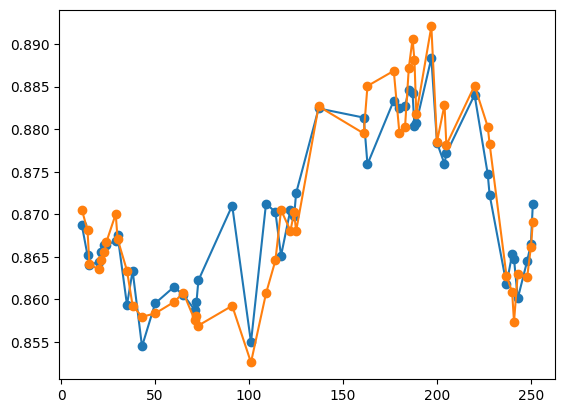

In [43]:
import matplotlib.pyplot as plt
plt.plot(df_test_pred_d1, marker='o')
plt.plot(df_test['Close_Day_1'], marker='o')

In [44]:
df_test_pred_d2 = pd.DataFrame(Y_test_pred[:,1], Y_test.index)

In [45]:
df_test_pred_d2 = df_test_pred_d2.sort_index()

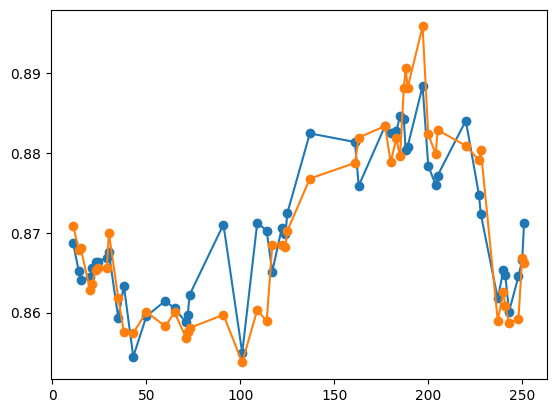

In [46]:
import matplotlib.pyplot as plt
plt.plot(df_test_pred_d1, marker='o')
plt.plot(df_test['Close_Day_2'], marker='o')

# Predict next 5 days

In [47]:
feats

,Date,opt_sine_offset,opt_sine_amp,opt_sine_freq,opt_sine_phase,opt_fourier_offset,opt_fourier_cosamp,opt_fourier_cosfreq,opt_fourier_cosphase,opt_fourier_sinamp,...,ROC1,ROC5,ROC20,WILLIAMS14,RSI14,CMO9,DEMA9,TEMA9,STOCH14,Close
0,2023-11-04,0.870904,1.000000,1.000037,-0.000015,0.867808,-0.000526,1.301513,-1.361042,-0.000543,...,-1453.991975,-348.869503,-41.157688,-9529.994883,47.994844,-11.584598,-0.000661,-0.001663,47.994844,0.86707
1,2023-11-03,0.870947,1.000000,0.999947,-0.000017,0.867811,-0.015800,1.020890,1.711873,-0.015565,...,-116.465040,-341.141141,-104.869782,-7160.110705,56.730784,11.865286,0.000709,0.000153,56.730784,0.87077
2,2023-11-02,0.871637,0.996344,0.999789,0.001560,0.867625,0.772528,1.061765,-2.182285,-0.772383,...,-937.812560,-161.958133,-68.494154,-7174.840656,52.854249,0.285988,0.000739,0.000157,52.854249,0.86897
3,2023-11-01,0.871884,0.989384,1.000117,-0.001315,0.867384,2.653029,0.870333,-2.006040,-2.653532,...,-90.210953,-69.978798,-104.860241,-7160.683537,57.447552,13.144303,0.001656,0.001500,57.447552,0.87070
4,2023-10-31,0.871353,1.000000,1.000087,0.000039,0.867143,-0.098707,1.040771,0.414727,-0.099181,...,36.114855,390.145618,-149.912800,-6661.598232,62.395395,27.615052,0.002024,0.002197,62.395395,0.87240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,2022-11-10,0.870689,1.003614,1.000775,-0.005412,0.874682,-1.581326,1.019214,0.193747,-1.579860,...,435.349845,-223.173287,200.866413,-3501.951480,55.815104,18.412148,0.003664,0.007305,55.815104,0.88130
258,2022-11-09,0.868165,1.008128,1.000185,-0.001941,0.874790,-1.610089,0.986844,0.165342,1.608514,...,-377.655909,-118.574216,-85.449269,-3537.200676,51.124727,5.037130,-0.000556,0.002213,51.124727,0.87253
259,2022-11-08,0.866421,1.008049,1.000476,-0.002746,0.874477,-1.536818,0.926602,0.247811,-1.535539,...,-112.899490,-91.378697,-111.963584,-4055.350522,49.571716,0.448199,-0.002047,0.000771,49.571716,0.86979
260,2022-11-07,0.862762,1.179504,1.000778,-0.004185,0.873898,4.787608,1.070146,-3.465122,-4.788463,...,159.854240,-146.538900,-94.815413,-4026.074358,53.210183,11.707334,-0.002751,0.000443,53.210183,0.87614


In [48]:
def prepare_for_pred(df: pd.DataFrame, n_lag_features: int = 10):
    df = df.copy()
    df.drop(['t'], axis=1)
    X = []
    
    for col in df.columns:
        if col == 'Date':
            X.append(df[col])
        elif col != 'Close':
            col_lag_features = pd.DataFrame()
            for i in range(n_lag_features):
                lag_feature_name = f'{col}_Lag_{i}'
                col_lag_features[lag_feature_name] = df[col].shift(-i)
            X.append(col_lag_features)
        
    df = pd.concat(X, axis=1)
    df.dropna(inplace=True)
    return df


In [49]:
input_feats = prepare_for_pred(feats, n_lag_features).iloc[[0]]
input_feats

,Date,opt_sine_offset_Lag_0,opt_sine_offset_Lag_1,opt_sine_offset_Lag_2,opt_sine_offset_Lag_3,opt_sine_offset_Lag_4,opt_sine_offset_Lag_5,opt_sine_offset_Lag_6,opt_sine_offset_Lag_7,opt_sine_offset_Lag_8,...,STOCH14_Lag_0,STOCH14_Lag_1,STOCH14_Lag_2,STOCH14_Lag_3,STOCH14_Lag_4,STOCH14_Lag_5,STOCH14_Lag_6,STOCH14_Lag_7,STOCH14_Lag_8,STOCH14_Lag_9
0,2023-11-04,0.870904,0.870947,0.871637,0.871884,0.871353,0.871324,0.871417,0.870662,0.869772,...,47.994844,56.730784,52.854249,57.447552,62.395395,61.489538,58.739189,66.426068,63.191878,62.784618


In [50]:
input_feats = input_feats.drop(columns=['Date'])
input_feats

,opt_sine_offset_Lag_0,opt_sine_offset_Lag_1,opt_sine_offset_Lag_2,opt_sine_offset_Lag_3,opt_sine_offset_Lag_4,opt_sine_offset_Lag_5,opt_sine_offset_Lag_6,opt_sine_offset_Lag_7,opt_sine_offset_Lag_8,opt_sine_offset_Lag_9,...,STOCH14_Lag_0,STOCH14_Lag_1,STOCH14_Lag_2,STOCH14_Lag_3,STOCH14_Lag_4,STOCH14_Lag_5,STOCH14_Lag_6,STOCH14_Lag_7,STOCH14_Lag_8,STOCH14_Lag_9
0,0.870904,0.870947,0.871637,0.871884,0.871353,0.871324,0.871417,0.870662,0.869772,0.868797,...,47.994844,56.730784,52.854249,57.447552,62.395395,61.489538,58.739189,66.426068,63.191878,62.784618


In [51]:
input_feats_scaled = scaler.transform(input_feats)

In [52]:
input_feats_scaled_reduced = pca.transform(input_feats_scaled)

In [53]:
preds_scaled = pd.DataFrame()
for i in range(1, n_days_ahead + 1):
    preds_scaled[f'Close_Day_{i}'] = svrs[i-1].predict(input_feats_scaled_reduced)
preds_scaled

,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5
0,-0.236034,-0.350321,-0.2488,-0.352755,-0.425951


In [54]:
preds_unscaled = scaler_y.inverse_transform(preds_scaled)

In [55]:
pd.DataFrame(preds_unscaled, columns=preds_scaled.columns)

,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5
0,0.86744,0.866301,0.867442,0.866234,0.865444


In [56]:
outfile = 'predictions_T_svr.csv'

# Save the NumPy matrix to the CSV file (append mode)
with open(outfile, 'a') as f:
    np.savetxt(f, preds_unscaled, delimiter=',')